In [1]:
!nvidia-smi

Sun Oct  6 15:32:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.8 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1.2-cp310-cp310-linux_x86_64.whl size=660544 sha256=92fffba304fed44aa62a7ef1e3ba9e645885d2a0aaad40b585e99dc5e3ea7ed3
  Stored in directory: /root/.cache/pip/wheels/70/63/40/4bf006182f942d3516b71bb2ff3b57ccbdb8b2c0ee81882b6e
Successfully built pycuda


In [3]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def read_rgb_image(image_path):
    try:
        # Считываем изображение с помощью OpenCV
        img = cv2.imread(image_path)
        img = cv2.resize(img, (255, 255))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

    except Exception as e:
        print("Ошибка при чтении изображения:", str(e))
        return None

Изображение успешно загружено!
Размер изображения: (255, 255, 3)


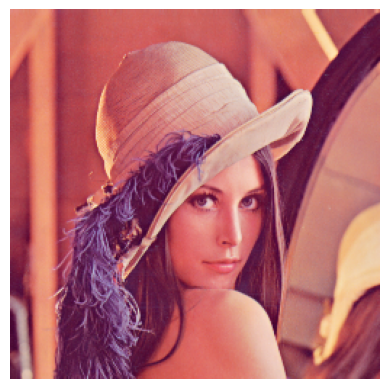

In [5]:
image_path = "Lena.bmp"  # Путь к изображению

# Чтение изображения
image = read_rgb_image(image_path)

if image is not None:
    print("Изображение успешно загружено!")
    print("Размер изображения:", image.shape)

    # Вывод изображения
    plt.imshow(image)
    plt.axis('off')
    plt.show()
else:
    print("Не удалось загрузить изображение.")

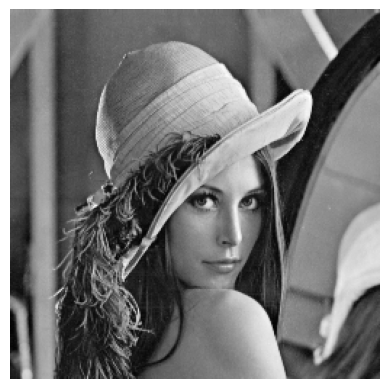

In [6]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Вывод изображения в консоль
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.show()

In [7]:
def add_noise(image, prob):
    noisy_image = np.copy(image)
    height, width = noisy_image.shape

    for i in range(height):
        for j in range(width):
            # Если вероятность меньше 0.1, то высветляем пиксель
            if np.random.random() <= prob:
                nois = np.random.randint(0, 256)
                black_or_white = np.random.randint(0, 2)
                if black_or_white:
                    noisy_image[i, j] = 255
                else:
                    noisy_image[i, j] = 0
    return noisy_image

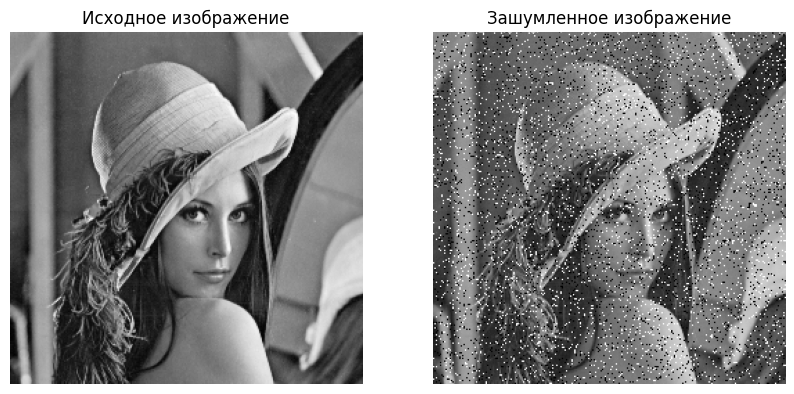

In [14]:
# Добавляем шум к изображению
noisy_image = add_noise(gray_image, prob=0.1)

# Выводим изображения до и после добавления шума
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title('Зашумленное изображение')
plt.axis('off')

plt.show()

In [15]:
cv2.imwrite('input_image.bmp', noisy_image)

True

Processing time: 0.000199 seconds
Output image saved to: output_image.bmp


/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()


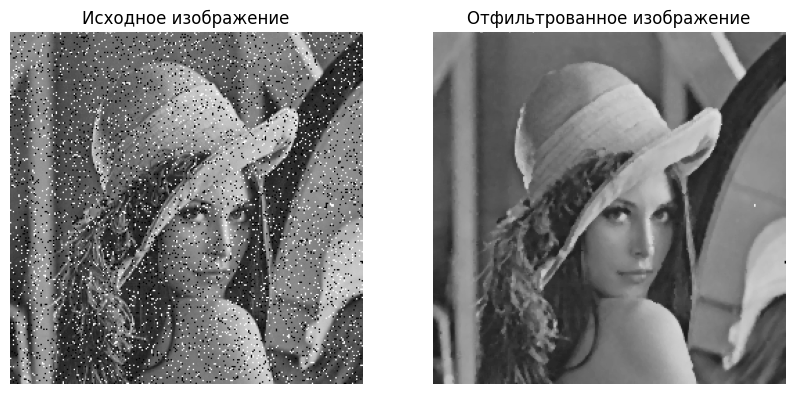

In [18]:
from PIL import Image
import pycuda.autoinit
import pycuda.driver as cuda
import pycuda.gpuarray as gpuarray
from pycuda.compiler import SourceModule
import time

# CUDA Kernel for the 9-point median filter
mod = SourceModule("""
__global__ void median_filter(unsigned char *input, unsigned char *output, int width, int height) {
    // Get pixel coordinates
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= width || y >= height) return;

    // 9-point array
    unsigned char neighbors[9];

    // Collect neighboring pixels
    for (int j = -1; j <= 1; j++) {
        for (int i = -1; i <= 1; i++) {
            int nx = min(max(x + i, 0), width - 1);
            int ny = min(max(y + j, 0), height - 1);
            neighbors[(j + 1) * 3 + (i + 1)] = input[ny * width + nx];
        }
    }

    // Simple Bubble sort to find median
    for (int i = 0; i < 9; i++) {
        for (int j = 0; j < 9 - i - 1; j++) {
            if (neighbors[j] > neighbors[j + 1]) {
                unsigned char temp = neighbors[j];
                neighbors[j] = neighbors[j + 1];
                neighbors[j + 1] = temp;
            }
        }
    }

    // Store median in output
    output[y * width + x] = neighbors[4]; // The median is at index 4
}
""")

def apply_median_filter(image_path, output_path):
    # Load the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image_data = np.array(image, dtype=np.uint8)

    height, width = image_data.shape

    # Allocate GPU memory
    input_gpu = cuda.mem_alloc(image_data.nbytes)
    output_gpu = cuda.mem_alloc(image_data.nbytes)

    # Copy data to GPU
    cuda.memcpy_htod(input_gpu, image_data)

    # Define block and grid size
    block_size = 16
    grid_size_x = (width + block_size - 1) // block_size
    grid_size_y = (height + block_size - 1) // block_size

    # Start timing
    start_time = time.time()

    # Launch kernel
    func = mod.get_function("median_filter")
    func(input_gpu, output_gpu, np.int32(width), np.int32(height),
         block=(block_size, block_size, 1), grid=(grid_size_x, grid_size_y))

    # Copy result back to host
    output_data = np.empty_like(image_data)
    cuda.memcpy_dtoh(output_data, output_gpu)

    # Stop timing
    end_time = time.time()
    processing_time = end_time - start_time

    # Save output image
    output_image = Image.fromarray(output_data)
    output_image.save(output_path)

    print(f"Processing time: {processing_time:.6f} seconds")
    print(f"Output image saved to: {output_path}")

    # Выводим изображения до и после медианного фильтра
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_data, cmap='gray')
    plt.title('Исходное изображение')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(output_data, cmap='gray')
    plt.title('Отфильтрованное изображение')
    plt.axis('off')

    plt.show()


apply_median_filter('input_image.bmp', 'output_image.bmp')